In [75]:
# import things
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.applications import ResNet50
import tensorflow_addons as tfa
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import keras.backend as K
import numpy as np
from patchify import patchify, unpatchify
import glob
import matplotlib.pyplot as plt
import cv2
import warnings
import sys
import os

warnings.filterwarnings("ignore")
print(os.getcwd())

/home/y2b/tasks/task5/ResNet


In [76]:
# REQUIREMENT: Do not add code from Tasks 2 or 4
# REQUIREMENT: All dataset prep (crop/pad/patch/directory structure) must be finalize before attempting this task.
patch_size = 256

In [77]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        # Threshold predictions
        y_pred = K.cast(K.greater(y_pred, 0.5), K.dtype(y_true))
        
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        # Threshold predictions
        y_pred = K.cast(K.greater(y_pred, 0.5), K.dtype(y_true))
        
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [78]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100,
    decay_rate=0.9,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [79]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_12[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [80]:
def resnet_unet_model(img_height, img_width, img_channels):
    input_shape = (img_height, img_width, img_channels)
    inputs = layers.Input(shape=input_shape)

    # Load ResNet50 as the encoder
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Contracting Path (Encoder)
    c1 = base_model.get_layer("conv1_relu").output  # 128x128 if input is 256
    c2 = base_model.get_layer("conv2_block3_out").output  # 64x64
    c3 = base_model.get_layer("conv3_block4_out").output  # 32x32
    c4 = base_model.get_layer("conv4_block6_out").output  # 16x16
    c5 = base_model.get_layer("conv5_block3_out").output  # 8x8

    # Expansive Path (Decoder)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)  # 16x16
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Dropout(0.3)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)  # 32x32
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)  # 64x64
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)  # 128x128
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    u10 = layers.Conv2DTranspose(1, (2, 2), strides=(2, 2), padding='same')(c9) #256x256

    outputs = layers.Activation('sigmoid')(u10) #Sigmoid activation

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1])

    return model

In [81]:
model = resnet_unet_model(256, 256, 3)

In [82]:
# Setup a generator for training
train_image_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    horizontal_flip=True
                                    )

train_image_generator = train_image_datagen.flow_from_directory(
    '../../dataset_patched_256/train_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='rgb',
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator(horizontal_flip=True)

train_mask_generator = train_mask_datagen.flow_from_directory(
    '../../dataset_patched_256/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

Found 7066 images belonging to 2 classes.
Found 7066 images belonging to 2 classes.


In [83]:
# Setup a generator for validation
val_image_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    horizontal_flip=True
                                    )

val_image_generator = val_image_datagen.flow_from_directory(
    '../../dataset_patched_256/val_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='rgb',
    seed=42
)

# Training masks
val_mask_datagen = ImageDataGenerator(horizontal_flip=True)

val_mask_generator = val_mask_datagen.flow_from_directory(
    '../../dataset_patched_256/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

Found 1553 images belonging to 2 classes.
Found 1553 images belonging to 2 classes.


In [84]:
# EarlyStopping()
from keras.callbacks import EarlyStopping

def combine_generator(image_generator, mask_generator):
    while True:
        yield (next(image_generator), next(mask_generator))

val_generator = combine_generator(val_image_generator, val_mask_generator)
train_generator = combine_generator(train_image_generator, train_mask_generator)

steps_per_epoch = len(train_image_generator)
validation_steps = len(val_image_generator)

early_stopping = EarlyStopping(monitor='val_f1', patience=10, restore_best_weights=True, mode='max')

In [85]:
for x, y in train_generator:
    print(f"Input shape: {x.shape}, Label shape: {y.shape}")
    break

print(model.output_shape)

Input shape: (16, 256, 256, 3), Label shape: (16, 256, 256, 1)
(None, 256, 256, 1)


In [86]:
# This is where the magic happens
# REQUIREMENT: The epoch logs must be visible showing validation loss and validation f1.
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=30,
                    batch_size=16,
                    callbacks=early_stopping,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                   )

Epoch 1/30


2025-01-09 16:14:52.493665: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


442/442 [==============================] - 115s 145ms/step - loss: 0.0418 - f1: 0.6511 - val_loss: 7465529.0000 - val_f1: 0.0000e+00
Epoch 2/30
442/442 [==============================] - 63s 142ms/step - loss: 0.0285 - f1: 0.7869 - val_loss: 0.0633 - val_f1: 0.4682
Epoch 3/30
442/442 [==============================] - 64s 144ms/step - loss: 0.0253 - f1: 0.8016 - val_loss: 0.0378 - val_f1: 0.7311
Epoch 4/30
442/442 [==============================] - 62s 141ms/step - loss: 0.0241 - f1: 0.8103 - val_loss: 0.0318 - val_f1: 0.7738
Epoch 5/30
442/442 [==============================] - 63s 144ms/step - loss: 0.0240 - f1: 0.8121 - val_loss: 0.0378 - val_f1: 0.7383
Epoch 6/30
442/442 [==============================] - 63s 143ms/step - loss: 0.0240 - f1: 0.8112 - val_loss: 0.0290 - val_f1: 0.7920
Epoch 7/30
442/442 [==============================] - 64s 145ms/step - loss: 0.0234 - f1: 0.8157 - val_loss: 0.0285 - val_f1: 0.7927
Epoch 8/30
442/442 [==============================] - 64s 145ms/step 

In [87]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
example_file_name = f'tudor_234803_resnet_model_{patch_size}px_iteration2.h5'
print(example_file_name)
model.save(example_file_name)

tudor_234803_resnet_model_256px_iteration2.h5


In [88]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.02785778045654297
Best validation f1: 0.8131840825080872


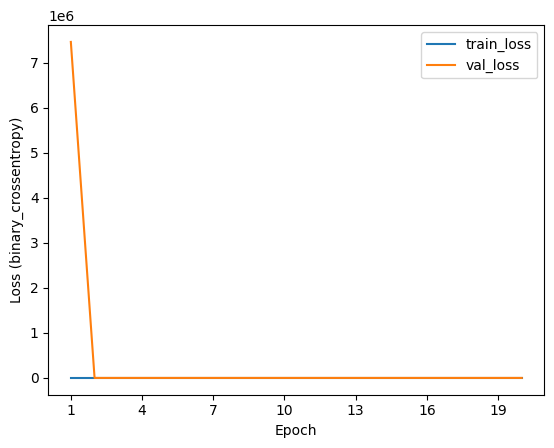

In [89]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

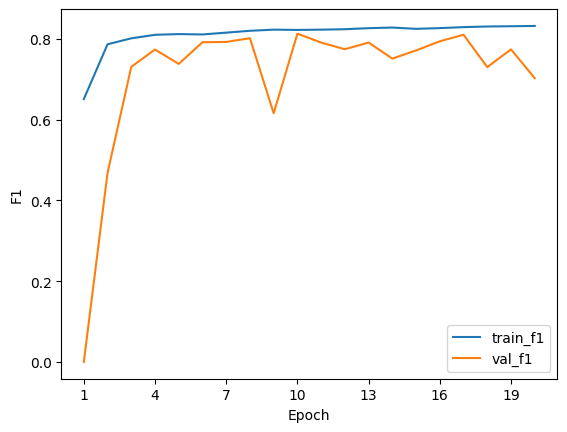

In [90]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
train_f1 = history.history['f1']
val_f1 = history.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))